In [94]:
%reset -f

# Ejercicio de Feedback Matemáticas y Estadística para la IA

## Enunciado
Eres un analista de datos contratado para explorar y extraer insights del dataset "International Football Results from 1872 to 2024", disponible en Kaggle https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to2017/data.
Este dataset contiene información sobre más de 47,000 partidos internacionales de fútbol masculino, desde el primer partido oficial en 1872 hasta la actualidad, incluyendo datos de torneos históricos como la Copa Mundial de la FIFA y partidos amistosos. Tu tarea es analizar este conjunto de datos utilizando las técnicas y herramientas aprendidas a lo largo del curso: estadística descriptiva, análisis EDA, modelos de clasificación y decisión, estimación bayesiana, depuración e imputación de datos, y redes neuronales avanzadas. Además, deberás responder preguntas clave sobre el impacto de jugar en casa, tendencias históricas, y los factores que influyen en los resultados. Este análisis se realizará de manera individual y se entregará como un informe final.

## Exploración Inicial y Análisis Descriptivo

### Exploración Inicial, EDA y Limpieza de Datos (1 puntos)

- Carga y explora el archivo results.csv:
    - Identifica las variables disponibles, tipos de datos y posibles errores (valores nulos, nombres duplicados).
    - Realiza una limpieza básica de los datos, incluyendo corrección de inconsistencias.
    - Implementa métodos de imputación para manejar datos faltantes.
        - Variables categóricas: imputación por moda.
        - Variables númericas: media, mediana o interpolación.

In [95]:
import pandas as pd
import numpy as np

Cargaremos el dataset usando la libreria `kagglehub` para simplificar el proceso

In [96]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("martj42/international-football-results-from-1872-to-2017")

In [97]:
results_df = pd.read_csv(path + "/results.csv")

Una vez descargado y cargado el dataset en un dataframe, pasamos a ver de manera resumida los descriptores estadisticos del dataset

In [98]:
# Obtenemos los primeros 5 registros
results_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [99]:
results_df['neutral'] = results_df['neutral'].astype(int)
results_df['date'] = pd.to_datetime(results_df['date'])

In [100]:
# Obtenemos las columnas numericas y algunas metrícas básicas
results_df.describe()


,date,home_score,away_score,neutral
count,47980,47980.000000,47980.000000,47980.000000
mean,1993-06-16 13:17:58.349312256,1.758691,1.182388,0.263193
min,1872-11-30 00:00:00,0.000000,0.000000,0.000000
25%,1979-10-17 00:00:00,1.000000,0.000000,0.000000
50%,1999-11-16 00:00:00,1.000000,1.000000,0.000000
75%,2012-06-17 00:00:00,2.000000,2.000000,1.000000
max,2025-01-05 00:00:00,31.000000,21.000000,1.000000
std,NaN,1.773369,1.400001,0.440371


In [101]:
def pretty_describe(df, decimals=2, include='all'):
    description = df.describe(include=include).round(decimals)
    return description.style \
        .set_properties(**{'background-color': 'lightblue', 'color': 'black'}) \
        .set_caption("Estadística descriptiva") 

In [102]:
display(pretty_describe(results_df, 2, 'number'))

,home_score,away_score,neutral
count,47980.000000,47980.000000,47980.000000
mean,1.760000,1.180000,0.260000
std,1.770000,1.400000,0.440000
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000
75%,2.000000,2.000000,1.000000
max,31.000000,21.000000,1.000000


In [103]:
#Obtenemos las columnas categoricas y algunas metrícas básicas
display(pretty_describe(results_df, 2, 'object'))

,home_team,away_team,tournament,city,country
count,47980,47980,47980,47980,47980
unique,326,319,181,2082,268
top,Brazil,Uruguay,Friendly,Kuala Lumpur,United States
freq,605,575,18042,732,1408


In [104]:
# Obtenemos los valores nulos o faltantes
results_df.isnull().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

Podemos ver como no existen valores faltantes entre los datos. Aún así, con proposito demostrativo, veremos como hacer la imputacion de datos en variables categoricas y numéricas

In [105]:
# Imputación por moda de todas las columnas categoricas
for column in results_df.select_dtypes(include=['object']).columns:
    results_df[column] = results_df[column].fillna(results_df[column].mode()[0])

In [106]:
# Imputación por media de todas las columnas numericas
for column in results_df.select_dtypes(include=['float64', 'int64']).columns:
    results_df[column] = results_df[column].fillna(results_df[column].mean())

- Exploración incial EDA:
    - Identifica distribuciones principales (histogramas, boxplots, etc).
    - Analiza correlaciones iniciales entre variables cuantitativas (matriz de correlación).
    - Si fuese necesario, crea variables derivadas, como, por ejemplo: diferencia de goles, década del partido, etc.
        - Analiza relaciones categóricas, como frecuencia de victorias locales o torneos más populares, utilizando gráficos de barras y/o mapas de calor.

In [107]:
import matplotlib.pyplot as plt

Mostramos un boxplot de los goles como local y visitante para ver como se distribuyen los datos y los outliers

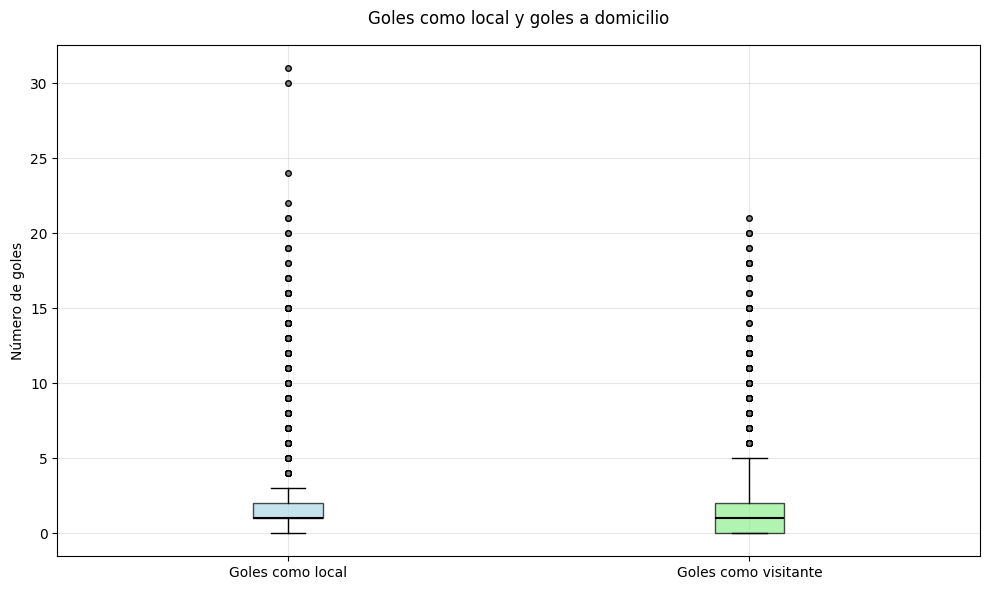

In [108]:
plt.figure(figsize=(10, 6))
box = plt.boxplot([results_df['home_score'], results_df['away_score']], 
                  tick_labels=['Goles como local', 'Goles como visitante'],
                  patch_artist=True,
                  medianprops=dict(color="black", linewidth=1.5),
                  flierprops=dict(marker='o', markerfacecolor='gray', markersize=4))

# Set colors for boxes
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Goles como local y goles a domicilio', pad=15)
plt.ylabel('Número de goles')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

Ahora haremos el análisis de correlaciones

In [109]:
def get_lower_triangle_mask(df):
    return np.triu(np.ones_like(df.corr(), dtype=bool))

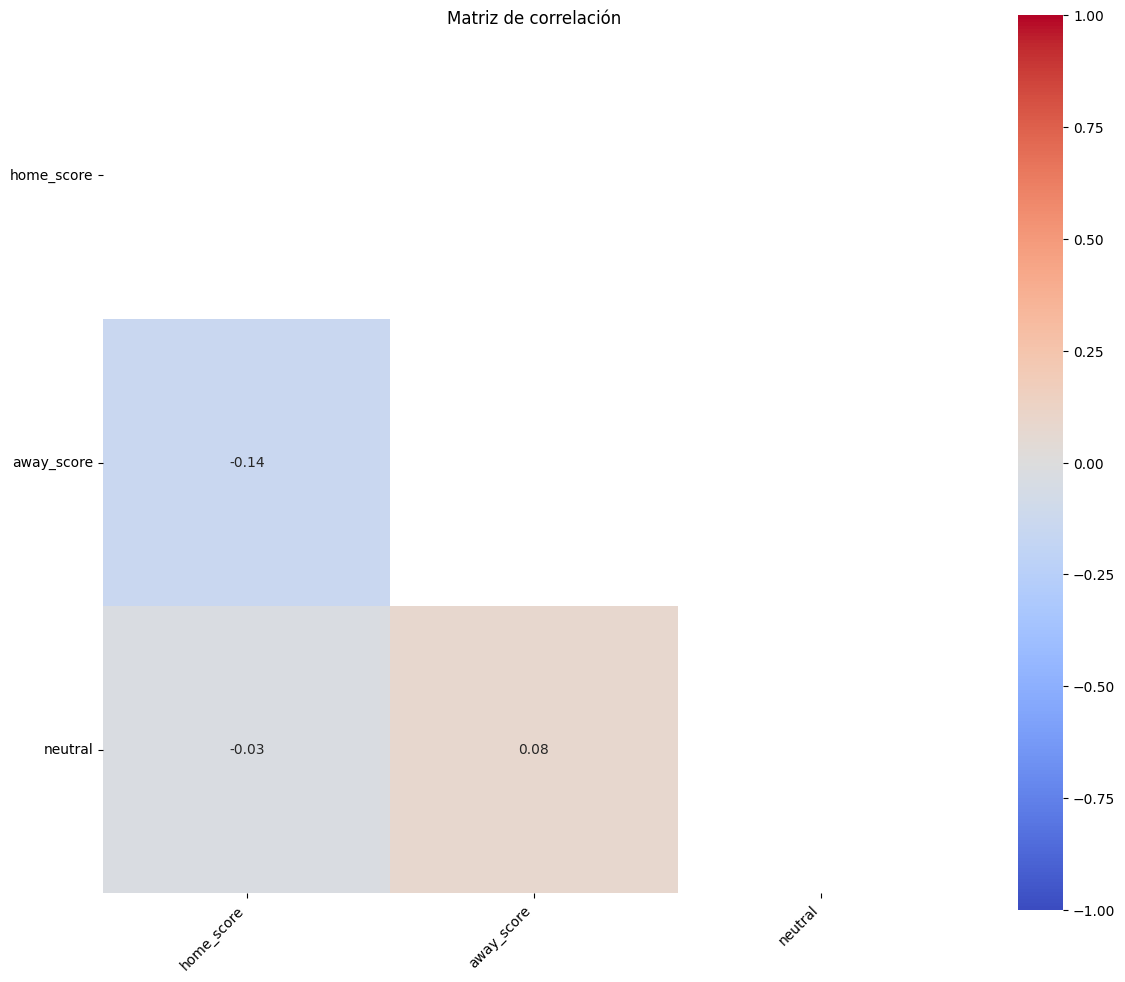

In [110]:
import seaborn as sns

results_df_numeric = results_df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12, 10))

sns.heatmap(results_df_numeric.corr(), 
			mask=get_lower_triangle_mask(results_df_numeric),
			annot=True, 
			cmap='coolwarm', 
			vmin=-1, 
			vmax=1, 
			center=0,
			fmt='.2f',
			square=True)

plt.title('Matriz de correlación')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Mostramos cuales son los 10 torneos más jugados excluyendo los amistos

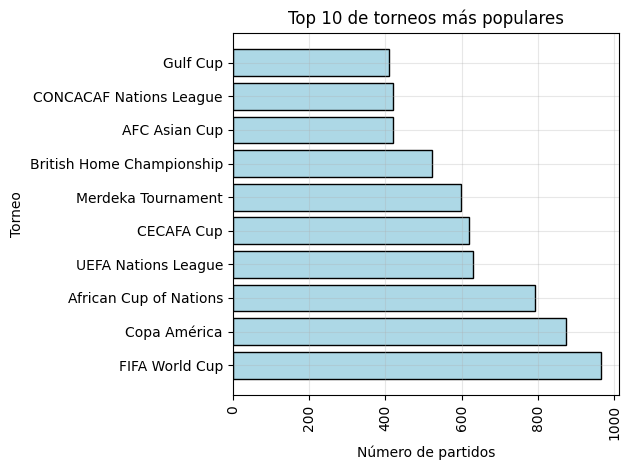

In [111]:
# Top 10 de torneos más populares sin contar amistosos y clasificatorias
top_10_tournaments = results_df['tournament'].loc[~results_df['tournament'].str.contains('Friendly|qualification')].value_counts().head(10)
plt.barh(top_10_tournaments.index, top_10_tournaments.values, color='lightblue', edgecolor='black')
plt.xticks(rotation=90)
plt.title('Top 10 de torneos más populares')
plt.xlabel('Número de partidos')
plt.ylabel('Torneo')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [112]:
results_df["result"] = np.where(results_df["home_score"] > results_df["away_score"], "home_win", np.where(results_df["home_score"] < results_df["away_score"], "away_win", "draw"))

Mostramos cual es la frecuencia de los resultados de los 20 equipos con mas partidos

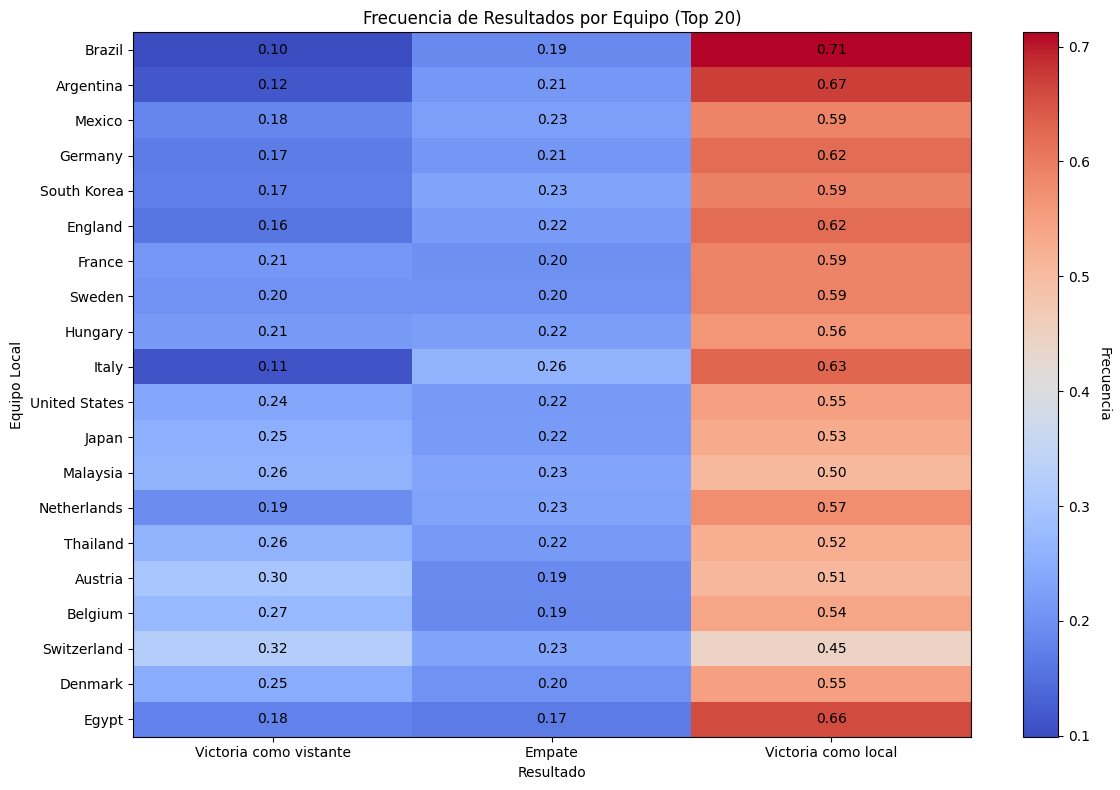

In [113]:
result_cross = pd.crosstab(results_df['home_team'], results_df['result'])
result_cross = result_cross.div(result_cross.sum(axis=1), axis=0)

# Para visualizar mejor los datos, usaremos los 20 equipos que más partidos han jugado
top_teams = results_df['home_team'].value_counts().head(20).index
result_cross_filtered = result_cross.loc[top_teams]

plt.figure(figsize=(12, 8))
plt.imshow(result_cross_filtered, cmap='coolwarm', aspect='auto')
plt.title('Frecuencia de Resultados por Equipo (Top 20)')
plt.xlabel('Resultado')
plt.ylabel('Equipo Local')
plt.yticks(range(len(top_teams)), top_teams)
plt.xticks(range(3), ['Victoria como vistante', 'Empate', 'Victoria como local'])

cbar = plt.colorbar(label='Frecuencia')
cbar.ax.set_ylabel('Frecuencia', rotation=270, labelpad=15)

for i in range(len(top_teams)):
    for j in range(3):
        plt.text(j, i, f'{result_cross_filtered.iloc[i, j]:.2f}', 
                ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

Podemos crear algunas columnas derivadas mas como la diferencia de goles, para luego saber el tipo de victoria, si es ajustada (por un gol) o amplia (2 o más)

In [114]:
# Diferencia de goles
results_df['goal_difference'] = results_df['home_score'] - results_df['away_score']
# Tipo de victoria, ajustada o amplia
results_df['victory_type'] = results_df['goal_difference'].apply(lambda x: 'draw' if abs(x) == 0 else 'narrow' if abs(x) == 1 else 'wide')
results_df['isFriendly'] = results_df['tournament'].apply(lambda x: 1 if 'Friendly' in x else 0)

Podemos visualizar el tipo de victoria segun si son torneos o partidos amistosos

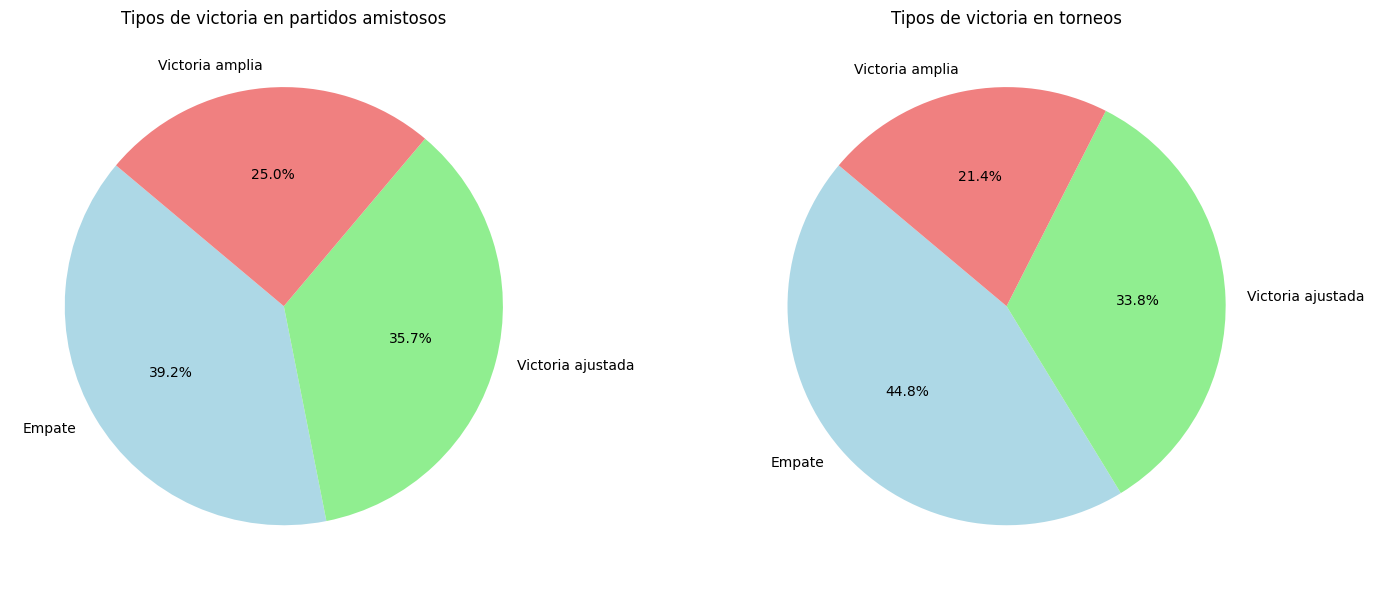

In [115]:
plt.figure(figsize=(15, 6))

# Subplot para partidos amistosos
plt.subplot(1, 2, 1)
plt.pie(results_df['victory_type'].loc[results_df['isFriendly'] == 1].value_counts(), 
    labels=['Empate', 'Victoria ajustada', 'Victoria amplia'],
    autopct='%1.1f%%', 
    startangle=140, 
    colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Tipos de victoria en partidos amistosos')

# Subplot para torneos 
plt.subplot(1, 2, 2)
plt.pie(results_df['victory_type'].loc[results_df['isFriendly'] == 0].value_counts(), 
    labels=['Empate', 'Victoria ajustada', 'Victoria amplia'],
    autopct='%1.1f%%', 
    startangle=140, 
    colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Tipos de victoria en torneos')

plt.tight_layout()
plt.show()

## Análisis Descriptivo Avanzado y EDA

- Responde preguntas clave utilizando análisis estadístico descriptivo:
    - ¿Cuál es la media de goles anotados por partido?
    - ¿Cuántos partidos se jugaron por década y en qué torneos?
    - ¿Qué equipos tienen el mayor rendimiento histórico jugando como
local?
- Presenta gráficos relevantes (barras, histogramas, boxplot, líneas de tiempo).
- Entrega un informe con análisis descriptivo avanzado, preguntas clave
respondidas y graficos relevantes.

Media de goles por partido

In [116]:
results_df['total_goals'] = results_df['home_score'] + results_df['away_score']
results_df['total_goals'].mean()

np.float64(2.9410796165068778)

Partidos jugados en cada década

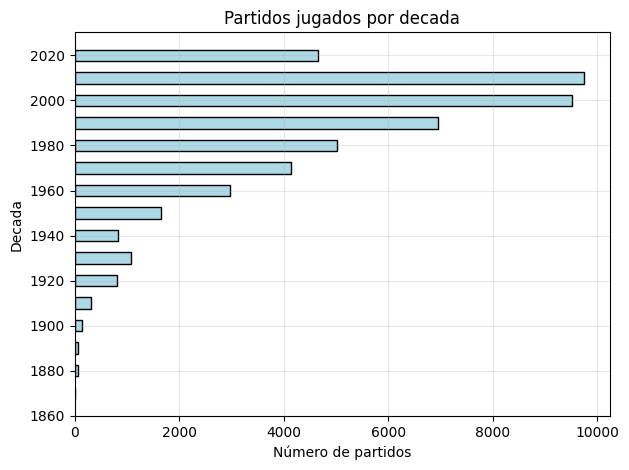

In [117]:
#Histograma de los partidos jugados por decada
results_df['decade'] = results_df['date'].dt.year // 10 * 10
plt.barh(
    results_df['decade'].value_counts().sort_index().index,
    results_df['decade'].value_counts().sort_index().values,
    color='lightblue',
    edgecolor='black',
    height=5)
plt.title('Partidos jugados por decada')
plt.xlabel('Número de partidos')
plt.ylabel('Decada')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Torneos jugados por decada, al ser tantos torneos, lo vamos a limitar a los 20 torneos mas jugados.

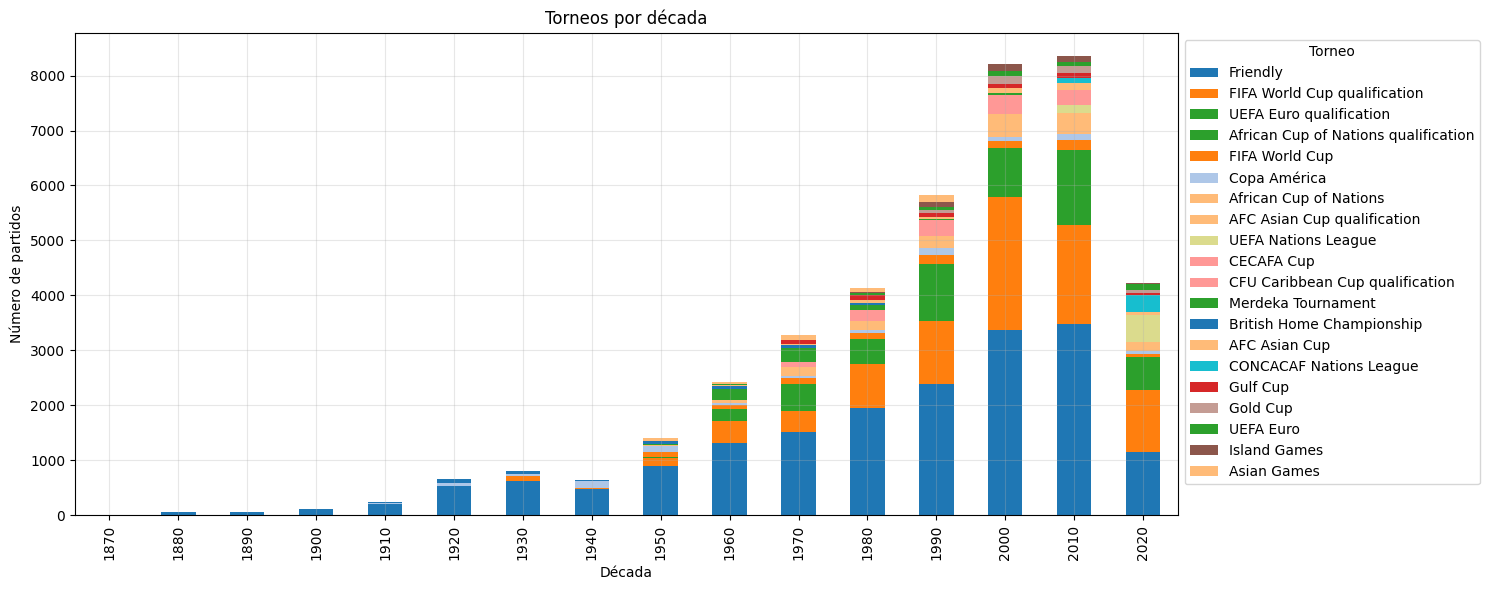

In [118]:
unique_tournaments = results_df['tournament'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_tournaments)))
tournament_color_map = dict(zip(unique_tournaments, colors))

tournament_decade = results_df.groupby('decade')['tournament'].value_counts().unstack().fillna(0)

top_20_tournaments = results_df['tournament'].value_counts().nlargest(20).index

tournament_decade_filtered = tournament_decade[top_20_tournaments]

ax = tournament_decade_filtered.plot(kind='bar', stacked=True, figsize=(15, 6), 
                                   color=[tournament_color_map[t] for t in top_20_tournaments])
plt.title('Torneos por década')
plt.xlabel('Década')
plt.ylabel('Número de partidos')
plt.grid(True, alpha=0.3)
plt.legend(title='Torneo', bbox_to_anchor=(1, 1), ncol=1)
plt.tight_layout()
plt.show()


Mostramos de manera completa todos los torneos jugados en la decada

In [119]:
for decade in sorted(tournament_decade.index):
    tournaments = results_df[results_df['decade'] == decade]['tournament'].unique()
    print(f"Década {decade}:")
    print(', '.join(sorted(tournaments)))

Década 1870:
Friendly
Década 1880:
British Home Championship, Friendly
Década 1890:
British Home Championship
Década 1900:
British Home Championship, Copa Lipton, Copa Newton, Copa Premio Honor Argentino, Friendly, Muratti Vase, Évence Coppée Trophy
Década 1910:
British Home Championship, Copa América, Copa Lipton, Copa Newton, Copa Premio Honor Argentino, Copa Premio Honor Uruguayo, Copa Roca, Far Eastern Championship Games, Friendly, Inter-Allied Games, Muratti Vase
Década 1920:
Balkan Cup, Baltic Cup, British Home Championship, Central European International Cup, Copa América, Copa Chevallier Boutell, Copa Lipton, Copa Newton, Copa Premio Honor Argentino, Copa Premio Honor Uruguayo, Copa Roca, Far Eastern Championship Games, Friendly, Muratti Vase, Nordic Championship, Olympic Games, Open International Championship, Peace Cup
Década 1930:
Balkan Cup, Baltic Cup, Bolivarian Games, British Home Championship, Central American and Caribbean Games, Central European International Cup, Cop

Mejor equipo jugando en casa quitando los partidos neutrales

In [120]:
home_win_rate = results_df[results_df['neutral'] == 0].groupby('home_team')['result'].apply(lambda x: (x == 'home_win').mean())
home_win_rate = home_win_rate.sort_values(ascending=False).head(10)
home_win_rate

home_team
Ellan Vannin          1.0
Ynys Môn              1.0
Padania               1.0
Micronesia            1.0
Parishes of Jersey    1.0
Provence              1.0
Iraqi Kurdistan       1.0
South Ossetia         1.0
Franconia             1.0
Luhansk PR            1.0
Name: result, dtype: float64

Ahora teniendo en cuenta los que tengan un minumo de 100 partidos jugados

In [121]:
home_win_rate = results_df[results_df['neutral'] == 0].groupby('home_team')['result'].apply(lambda x: (x == 'home_win').mean() if len(x) > 100 else np.nan)
home_win_rate = home_win_rate.dropna().sort_values(ascending=False).head(10)
home_win_rate

home_team
Brazil            0.732044
Iran              0.710900
Spain             0.704819
Ivory Coast       0.693780
Guinea            0.684211
Czech Republic    0.683099
Egypt             0.680851
Mexico            0.677083
Nigeria           0.674757
Ghana             0.673367
Name: result, dtype: float64

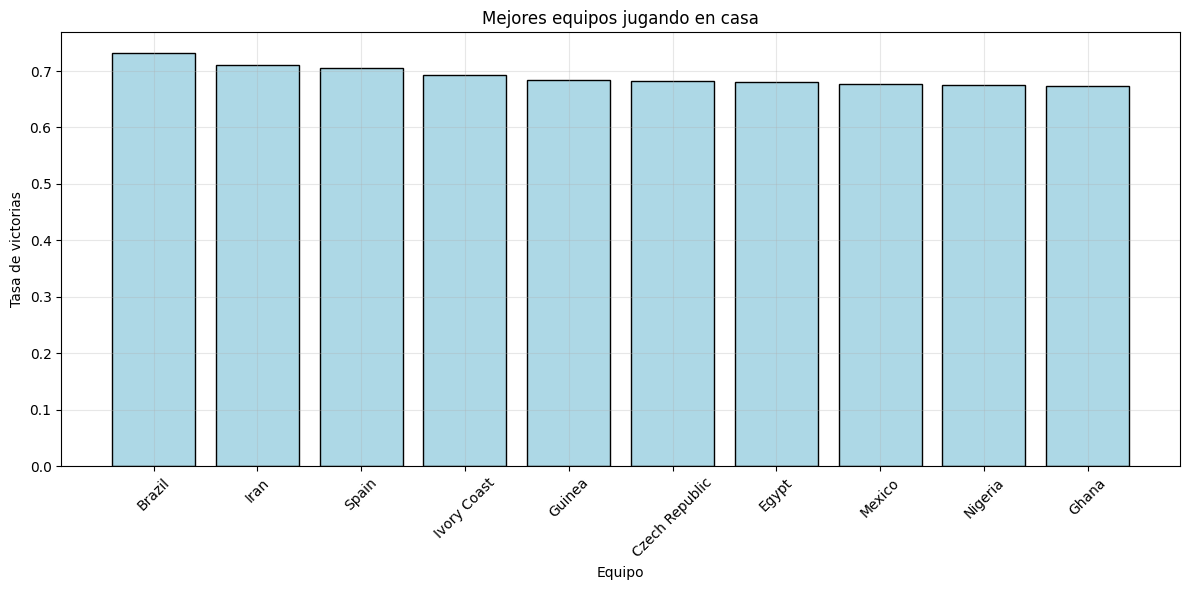

In [122]:
plt.figure(figsize=(12, 6))
plt.bar(home_win_rate.head(10).index, home_win_rate.head(10).values, color='lightblue', edgecolor='black')
plt.title('Mejores equipos jugando en casa')
plt.xlabel('Equipo')
plt.ylabel('Tasa de victorias')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Reducción de Dimensionalidad 

- Identificación de necesidades:
    - Determina si las variables derivadas son redundantes o altamente correlacionadas.
    - Si es necesario, usa el Análisis de Componentes Principales (PCA) para reducir dimensiones mientras mantienes información relevante.
- Pasos de PCA:
    - Selecciona variables numéricas derivadas, como goles, diferencias de goles y métricas adicionales.
    - Calcula la varianza explicada por cada componente principal.
    - Visualiza los dos primeros componentes para identificar patrones históricos o grupales.
- Aplicación en modelado
    - Utiliza las dimensiones reducidas como insumos para modelos predictivos.
- Entrega:
    - Visualizaciones del PCA y justificación del uso de dimensiones seleccionadas.

Primero nos quedamos con las columnas numéricas

In [123]:
numeric_df = results_df.select_dtypes(include=['float64', 'int64'])

Estandarizamos los datos

In [124]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_std_df = scaler.fit_transform(numeric_df)

numeric_std_df = pd.DataFrame(numeric_std_df, columns=numeric_df.columns)

Calculamos la correlación

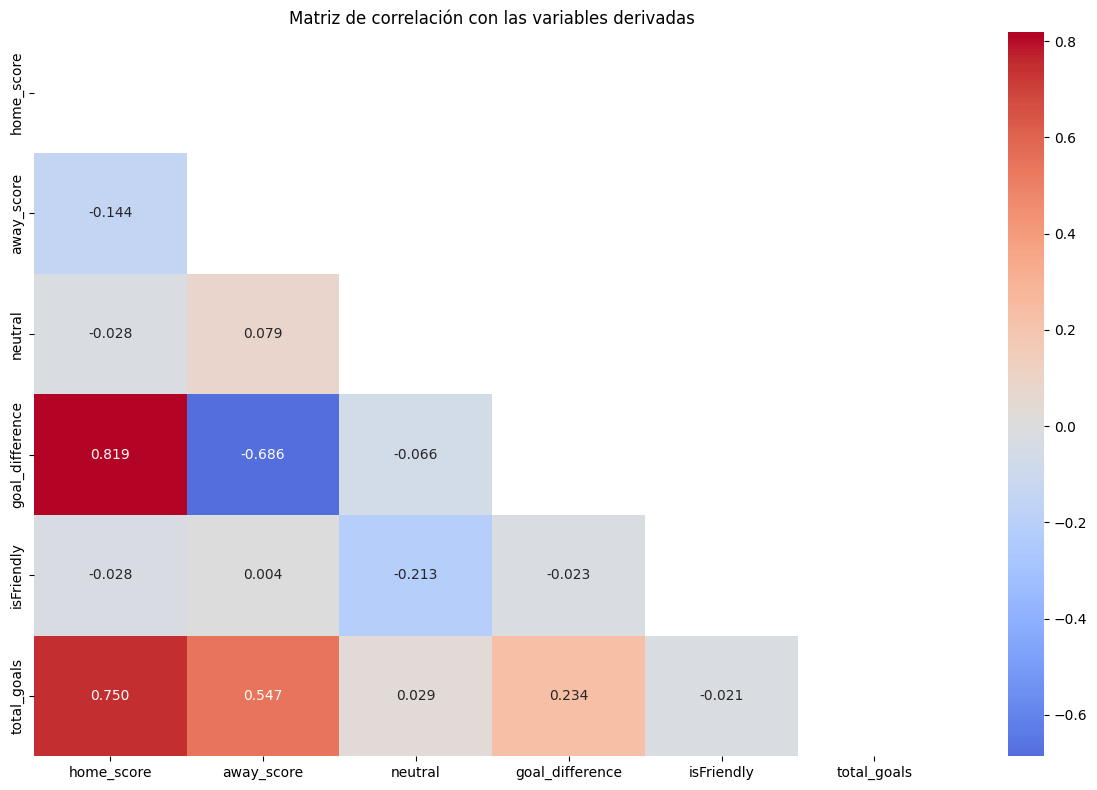

In [125]:
# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_std_df.corr(), 
            annot=True,
			cmap='coolwarm', 
            center=0,
            fmt='.3f',
            mask=get_lower_triangle_mask(numeric_std_df))
plt.title('Matriz de correlación con las variables derivadas')
plt.tight_layout()
plt.show()


Mostramos las 10 variables más correlacionadas en una tabla

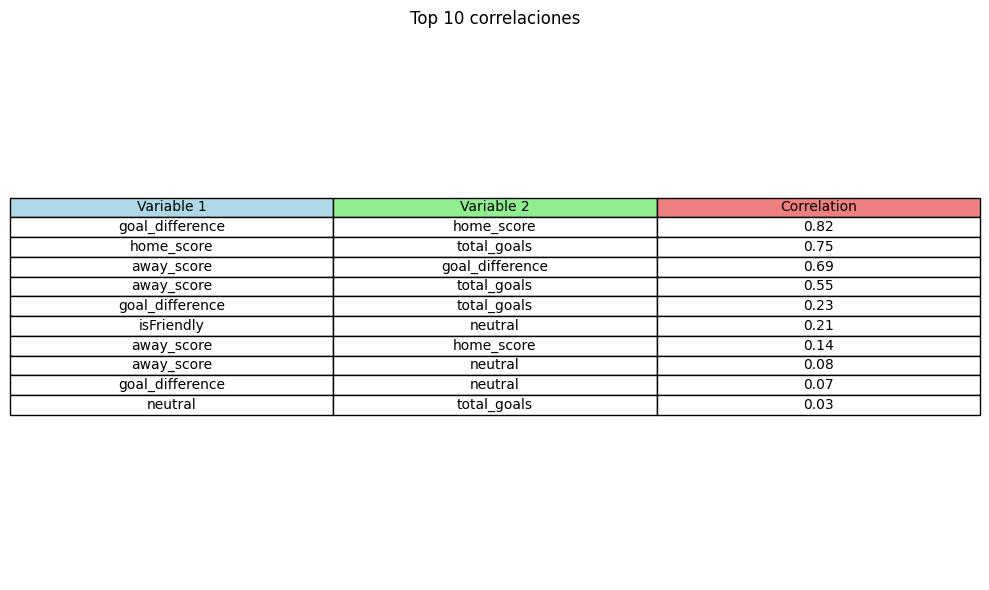

In [126]:
correlation = numeric_df.corr()
correlation = correlation.stack().reset_index()
correlation.columns = ['Variable 1', 'Variable 2', 'Correlation']
correlation['Correlation'] = correlation['Correlation'].abs()
correlation = correlation[correlation['Correlation'] < 1]
correlation = correlation.sort_values('Correlation', ascending=False)
correlation = correlation[correlation['Variable 1'] < correlation['Variable 2']]
correlation['Correlation'] = correlation['Correlation'].apply(lambda x: round(x, 2))

plt.figure(figsize=(10, 6))
plt.table(cellText=correlation.head(10).values,
          colLabels=correlation.columns,
          cellLoc='center',
          loc='center',
          colColours=['lightblue', 'lightgreen', 'lightcoral'])
plt.axis('off')
plt.title('Top 10 correlaciones')
plt.tight_layout()
plt.show()

Nos quedamos solo con esas columnas para hacer PCA

In [127]:
new_columns = correlation.head(10)['Variable 1'].unique().tolist() + correlation.head(10)['Variable 2'].unique().tolist()
new_columns = list(set(new_columns))
new_columns

['home_score',
 'total_goals',
 'away_score',
 'goal_difference',
 'isFriendly',
 'neutral']

In [128]:
pca_df = numeric_std_df[new_columns]
# Inicializamos PCA
pca = PCA(n_components=2)

# Ajustamos y transformamos los datos
results_df_pca = pca.fit_transform(pca_df)

# Creamos un DataFrame con los resultados
results_df_pca = pd.DataFrame(results_df_pca, columns=['PC1', 'PC2'])
results_df_pca.head()

,PC1,PC2
0,-1.131492,-1.699844
1,1.600164,1.204526
2,0.234336,-0.247659
3,-0.004425,0.664889
4,1.275392,-0.890389


In [129]:
# Varianza explicada por cada componente
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Varianza explicada por PC1: {explained_variance_ratio[0]:.2f}")
print(f"Varianza explicada por PC2: {explained_variance_ratio[1]:.2f}")

Varianza explicada por PC1: 0.38
Varianza explicada por PC2: 0.29


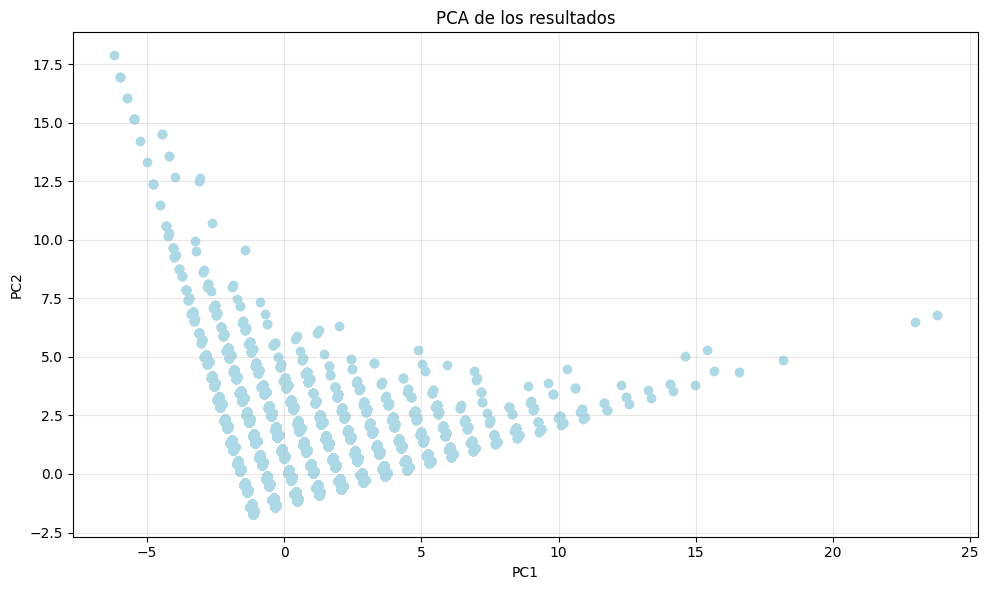

In [130]:
#Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.scatter(results_df_pca['PC1'], results_df_pca['PC2'], color='lightblue')
plt.title('PCA de los resultados')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Análisis Avanzado y Modelos Predictivos

## Ventaja de Localía y Probabilidades Condicionales 

- Usa el Teorema de Bayes para calcular:
    - La probabilidad de que un equipo gane si juega como local.
    - La probabilidad de empate en un campo neutral.
- Representa tus hallazgos en tablas y gráficos explicativos

In [131]:
# Añadiendo columnas para el resultado de cada partido
results_df['result'] = results_df.apply(
    lambda row: 'home_win' if row['home_score'] > row['away_score']
    else ('away_win' if row['home_score'] < row['away_score'] else 'draw'),
    axis=1
)

# Calculando probabilidades para el teorema de Bayes
# P(Victoria Local | Local) = P(Victoria Local y Local) / P(Local)
# P(Empate Neutral) = P(Empate y Neutral) / P(Neutral)

# Total de partidos
total_matches = len(results_df)

# Probabilidad de que un partido sea local o neutral
p_home = len(results_df[results_df['neutral'] == False]) / total_matches
p_neutral = len(results_df[results_df['neutral'] == True]) / total_matches

# Probabilidades de victoria local
home_matches = results_df[results_df['neutral'] == False]
p_home_win_and_home = len(home_matches[home_matches['result'] == 'home_win']) / total_matches

p_home_win_given_home = p_home_win_and_home / p_home

# Probabilidades de empate en campo neutral
neutral_matches = results_df[results_df['neutral'] == True]
p_draw_and_neutral = len(neutral_matches[neutral_matches['result'] == 'draw']) / total_matches

p_draw_given_neutral = p_draw_and_neutral / p_neutral

results = {
    "P(Home Win | Home)": p_home_win_given_home,
    "P(Draw | Neutral)": p_draw_given_neutral
}

print("Resultados:")
print(f'    P(Victoria local | Local) {p_home_win_given_home}')
print(f'    P(Empate | Neutral) {p_draw_given_neutral}')


Resultados:
    P(Victoria local | Local) 0.5071283095723015
    P(Empate | Neutral) 0.2237092176116566


Mostramos los resultados en una gráfica

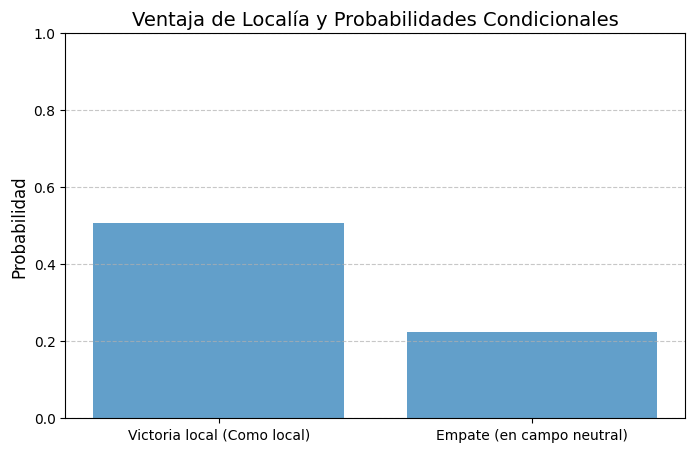

In [132]:
probabilities_df = pd.DataFrame({
    "Condition": ["Victoria local (Como local)", "Empate (en campo neutral)"],
    "Probability": [results["P(Home Win | Home)"], results["P(Draw | Neutral)"]]
})

# Bar plot for the probabilities
plt.figure(figsize=(8, 5))
plt.bar(probabilities_df["Condition"], probabilities_df["Probability"], alpha=0.7)
plt.title("Ventaja de Localía y Probabilidades Condicionales", fontsize=14)
plt.ylabel("Probabilidad", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Modelos de Clasificación

- Diseña un modelo para predecir el resultado de un partido (home_win, draw, away_win):
    - Selecciona variables relevantes como el torneo, localización, y goles anteriores.
    - Usa un modelo simple como árboles de decisión, regresión logística o clasificación bayesiana.
    - Evalúa el desempeño del modelo con métricas como precisión, F1-score y matriz de confusión.

Añadimos algunas variables derivadas nuevas que pueden ser interesantes para nuestro modelo

In [133]:
# Creamos columnas que representan si el equipo ganó, empató o perdió en el último partido como local y visitante
results_df["home_last_win"] = results_df.groupby("home_team")["result"].shift(1) == "home_win"
results_df["away_last_win"] = results_df.groupby("away_team")["result"].shift(1) == "away_win"
results_df["home_last_draw"] = results_df.groupby("home_team")["result"].shift(1) == "draw"
results_df["away_last_draw"] = results_df.groupby("away_team")["result"].shift(1) == "draw"
results_df["home_last_loss"] = results_df.groupby("home_team")["result"].shift(1) == "away_win"
results_df["away_last_loss"] = results_df.groupby("away_team")["result"].shift(1) == "home_win"

# Creamos columnas que representan los goles anotados y recibidos en los últimos partidos como local y visitante
results_df["home_last_goals_scored"] = results_df.groupby("home_team")["home_score"].shift(1)
results_df["away_last_goals_scored"] = results_df.groupby("away_team")["away_score"].shift(1)
results_df["home_last_goals_conceded"] = results_df.groupby("home_team")["away_score"].shift(1)
results_df["away_last_goals_conceded"] = results_df.groupby("away_team")["home_score"].shift(1)

# Creamos columnas que representan la tasa de victorias de los equipos en los últimos 10 partidos como local y visitante
results_df["home_win_rate"] = results_df.groupby("home_team")["result"].transform(lambda x: x.eq("home_win").rolling(10).mean())
results_df["away_win_rate"] = results_df.groupby("away_team")["result"].transform(lambda x: x.eq("away_win").rolling(10).mean())

Comprobamos si existen valores nulos para estas nuevas variable

In [134]:
results_df.isna().sum()

date                           0
home_team                      0
away_team                      0
home_score                     0
away_score                     0
tournament                     0
city                           0
country                        0
neutral                        0
result                         0
goal_difference                0
victory_type                   0
isFriendly                     0
total_goals                    0
decade                         0
home_last_win                  0
away_last_win                  0
home_last_draw                 0
away_last_draw                 0
home_last_loss                 0
away_last_loss                 0
home_last_goals_scored       326
away_last_goals_scored       319
home_last_goals_conceded     326
away_last_goals_conceded     319
home_win_rate               2565
away_win_rate               2577
dtype: int64

Para las columnas de (home/away)last_goals_scored y (home/away)last_goals_conceded, podemos imputar 0 porque es el primer partido de muchos países.

In [135]:
for column in ['home_last_goals_scored', 'away_last_goals_scored', 'home_last_goals_conceded', 'away_last_goals_conceded']:
    results_df[column] = results_df[column].fillna(0)

Para las variables home_win_rate y away_win_rate, usaremos la media

In [136]:
for column in ['home_win_rate', 'away_win_rate']:
    results_df[column] = results_df[column].fillna(results_df[column].mean())

Codificamos los equipos

In [137]:
from sklearn.preprocessing import LabelEncoder

home_uniques = results_df["home_team"].unique()
away_uniques = results_df["away_team"].unique()

uniques = np.unique(np.concatenate((home_uniques, away_uniques),0))

country_encoder = LabelEncoder()
country_encoder.fit(uniques)

results_df["away_team"] = country_encoder.transform(results_df["away_team"])
results_df["home_team"] = country_encoder.transform(results_df["home_team"])


Codificamos las ciudades y los torneos

In [138]:
# Hacemos lo mismo con la columna de torneos
tournament_encoder = LabelEncoder()
tournament_encoder.fit(results_df["tournament"])
results_df["tournament"] = tournament_encoder.transform(results_df["tournament"])

# Y tambien para la ciudad
city_encoder = LabelEncoder()
city_encoder.fit(results_df["city"])
results_df["city"] = city_encoder.transform(results_df["city"])


Finalmente eliminamos las columnas que contienen la etiqueta, como los goles, el tipo de victoria. Tambien eliminamos el pais en el que se juega porque esta contenido en si se juega en campo neutral o no.
Eliminamos tambien la fecha y la columna `isFriendly` porque tambien esta contenida en el torneo

In [139]:
results_df.drop(columns=["date", "home_score", "away_score", "goal_difference", "victory_type", "country", "isFriendly"], inplace=True)

results_df.head()

,home_team,away_team,tournament,city,neutral,result,total_goals,decade,home_last_win,away_last_win,home_last_draw,away_last_draw,home_last_loss,away_last_loss,home_last_goals_scored,away_last_goals_scored,home_last_goals_conceded,away_last_goals_conceded,home_win_rate,away_win_rate
0,254,91,88,655,0,draw,0,1870,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.493883,0.284417
1,91,254,88,1035,0,home_win,6,1870,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.493883,0.284417
2,254,91,88,655,0,home_win,3,1870,False,False,True,True,False,False,0.0,0.0,0.0,0.0,0.493883,0.284417
3,91,254,88,1035,0,draw,4,1870,True,False,False,False,False,True,4.0,2.0,2.0,4.0,0.493883,0.284417
4,254,91,88,655,0,home_win,3,1870,True,False,False,False,False,True,2.0,1.0,1.0,2.0,0.493883,0.284417


Separamos las variables predictora y objetivo y hacemos el split del dataset

In [140]:
from sklearn.model_selection import train_test_split

X = results_df.drop(columns=["result"])
y = results_df["result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Creamos una funcion que generaliza el entrenamiento y las metricas del modelo

In [141]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize


def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("\nPrecisión del Modelo en Conjunto de Prueba: {:.2f}%".format(accuracy * 100))

    print("\nInforme de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=['away_win', 'draw', 'home_win']))

    # Gráfico de matriz de confusión
    plt.figure(figsize=(15, 6))
    
    # Gráfico de matriz de confusión
    plt.subplot(1, 2, 1)
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['away_win', 'draw', 'home_win'], yticklabels=['away_win', 'draw', 'home_win'])
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    # Curvas ROC para múltiples clases
    plt.subplot(1, 2, 2)

    # Binarizamos la salida
    y_test_bin = label_binarize(y_test, classes=['away_win', 'draw', 'home_win'])
    y_pred_proba = model.predict_proba(X_test)

    # Calculamos la curva ROC micro-promedio y el área ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 3

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])

    # Agregamos todas las tasas de falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolamos todas las curvas ROC
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Promediamos y calculamos el AUC
    mean_tpr /= n_classes
    micro_auc = roc_auc_score(y_test_bin.ravel(), y_pred_proba.ravel())

    plt.plot(all_fpr, mean_tpr, color='blue', label=f'Curva ROC micro-promedio (AUC = {micro_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.title('Curva ROC (Multi-clase)')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend()

    plt.tight_layout()
    plt.show()

    if hasattr(model, "feature_importances_"):
        feature_importances = pd.DataFrame({
            'Característica': X_train.columns,
            'Importancia': model.feature_importances_
        }).sort_values(by='Importancia', ascending=False)
        print("\nImportancia de Características:")
        print(feature_importances)


Arbol de decisión:


Precisión del Modelo en Conjunto de Prueba: 61.67%

Informe de Clasificación:
              precision    recall  f1-score   support

    away_win       0.51      0.52      0.52      2678
        draw       0.61      0.60      0.61      2191
    home_win       0.68      0.67      0.68      4727

    accuracy                           0.62      9596
   macro avg       0.60      0.60      0.60      9596
weighted avg       0.62      0.62      0.62      9596



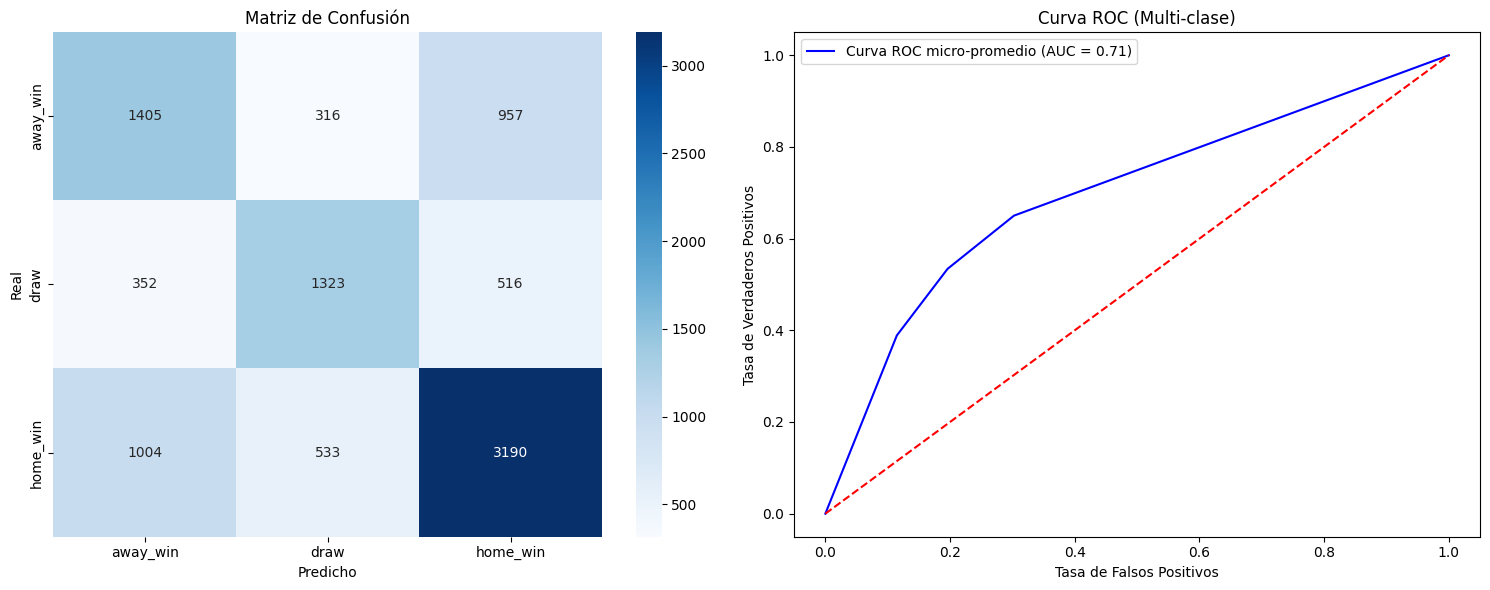


Importancia de Características:
              Característica  Importancia
5                total_goals     0.220970
18             away_win_rate     0.113528
17             home_win_rate     0.105528
1                  away_team     0.095429
3                       city     0.094563
0                  home_team     0.091480
2                 tournament     0.049178
6                     decade     0.045959
13    home_last_goals_scored     0.035931
16  away_last_goals_conceded     0.035614
14    away_last_goals_scored     0.029933
15  home_last_goals_conceded     0.027947
4                    neutral     0.011816
9             home_last_draw     0.008706
10            away_last_draw     0.007692
12            away_last_loss     0.007136
11            home_last_loss     0.007020
8              away_last_win     0.006359
7              home_last_win     0.005212


In [142]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
train_model(model, X_train, y_train)

Regresión logistica 


Precisión del Modelo en Conjunto de Prueba: 64.08%

Informe de Clasificación:
              precision    recall  f1-score   support

    away_win       0.60      0.57      0.58      2678
        draw       0.54      0.35      0.43      2191
    home_win       0.68      0.82      0.74      4727

    accuracy                           0.64      9596
   macro avg       0.61      0.58      0.58      9596
weighted avg       0.63      0.64      0.63      9596



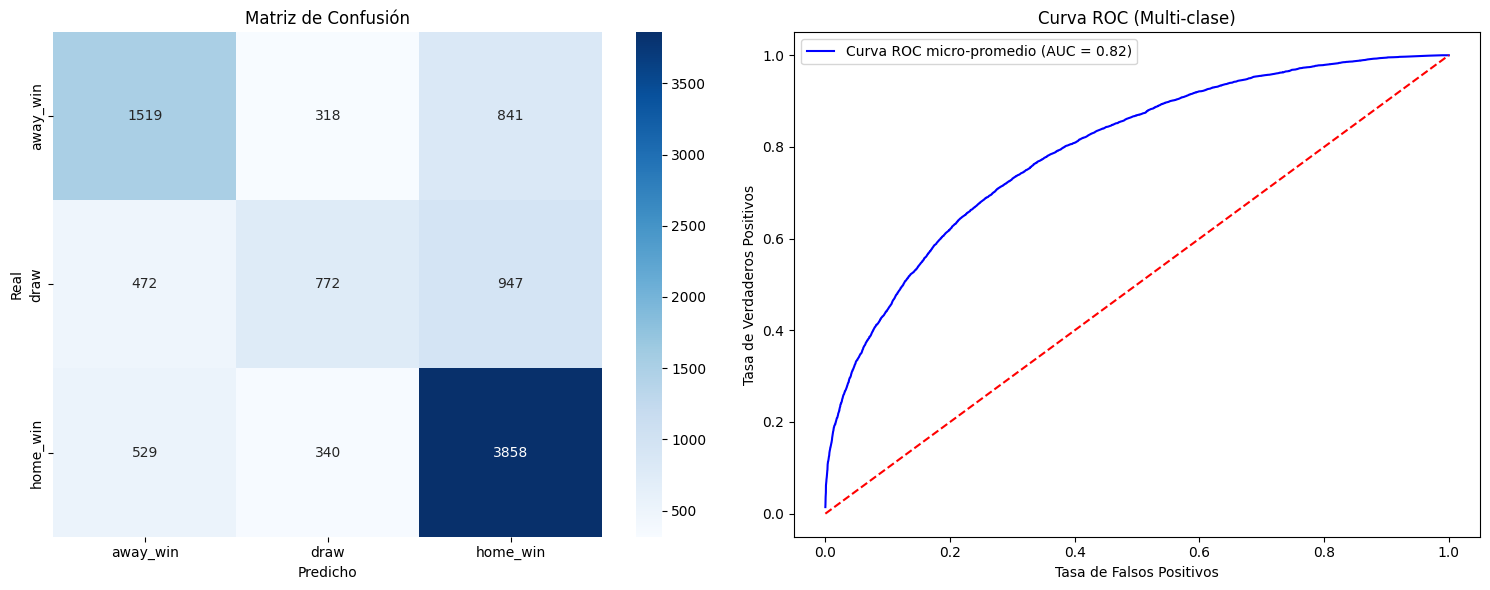

In [143]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42, max_iter=100, solver='newton-cholesky')
train_model(model, X_train, y_train)

Clasificación bayesiana


Precisión del Modelo en Conjunto de Prueba: 35.47%

Informe de Clasificación:
              precision    recall  f1-score   support

    away_win       0.32      0.42      0.36      2678
        draw       0.25      0.44      0.32      2191
    home_win       0.58      0.28      0.38      4727

    accuracy                           0.35      9596
   macro avg       0.38      0.38      0.35      9596
weighted avg       0.43      0.35      0.36      9596



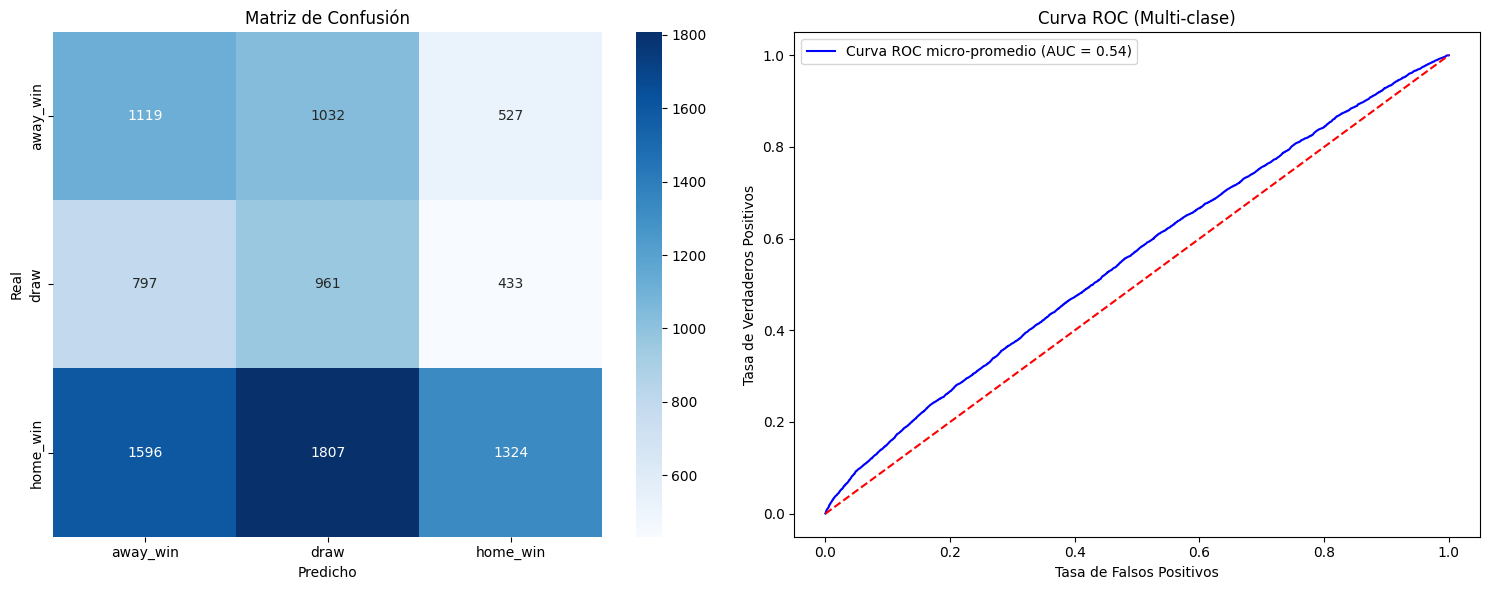

In [144]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
train_model(model, X_train, y_train)

# Redes y Técnicas Avanzadas

## Análisis de Grafos 

- Crea un grafo donde:
    - Los nodos representen equipos.
    - Las aristas correspondan a los partidos jugados entre ellos.
- Calcula métricas como centralidad, grado y componentes conectados para identificar equipos clave.

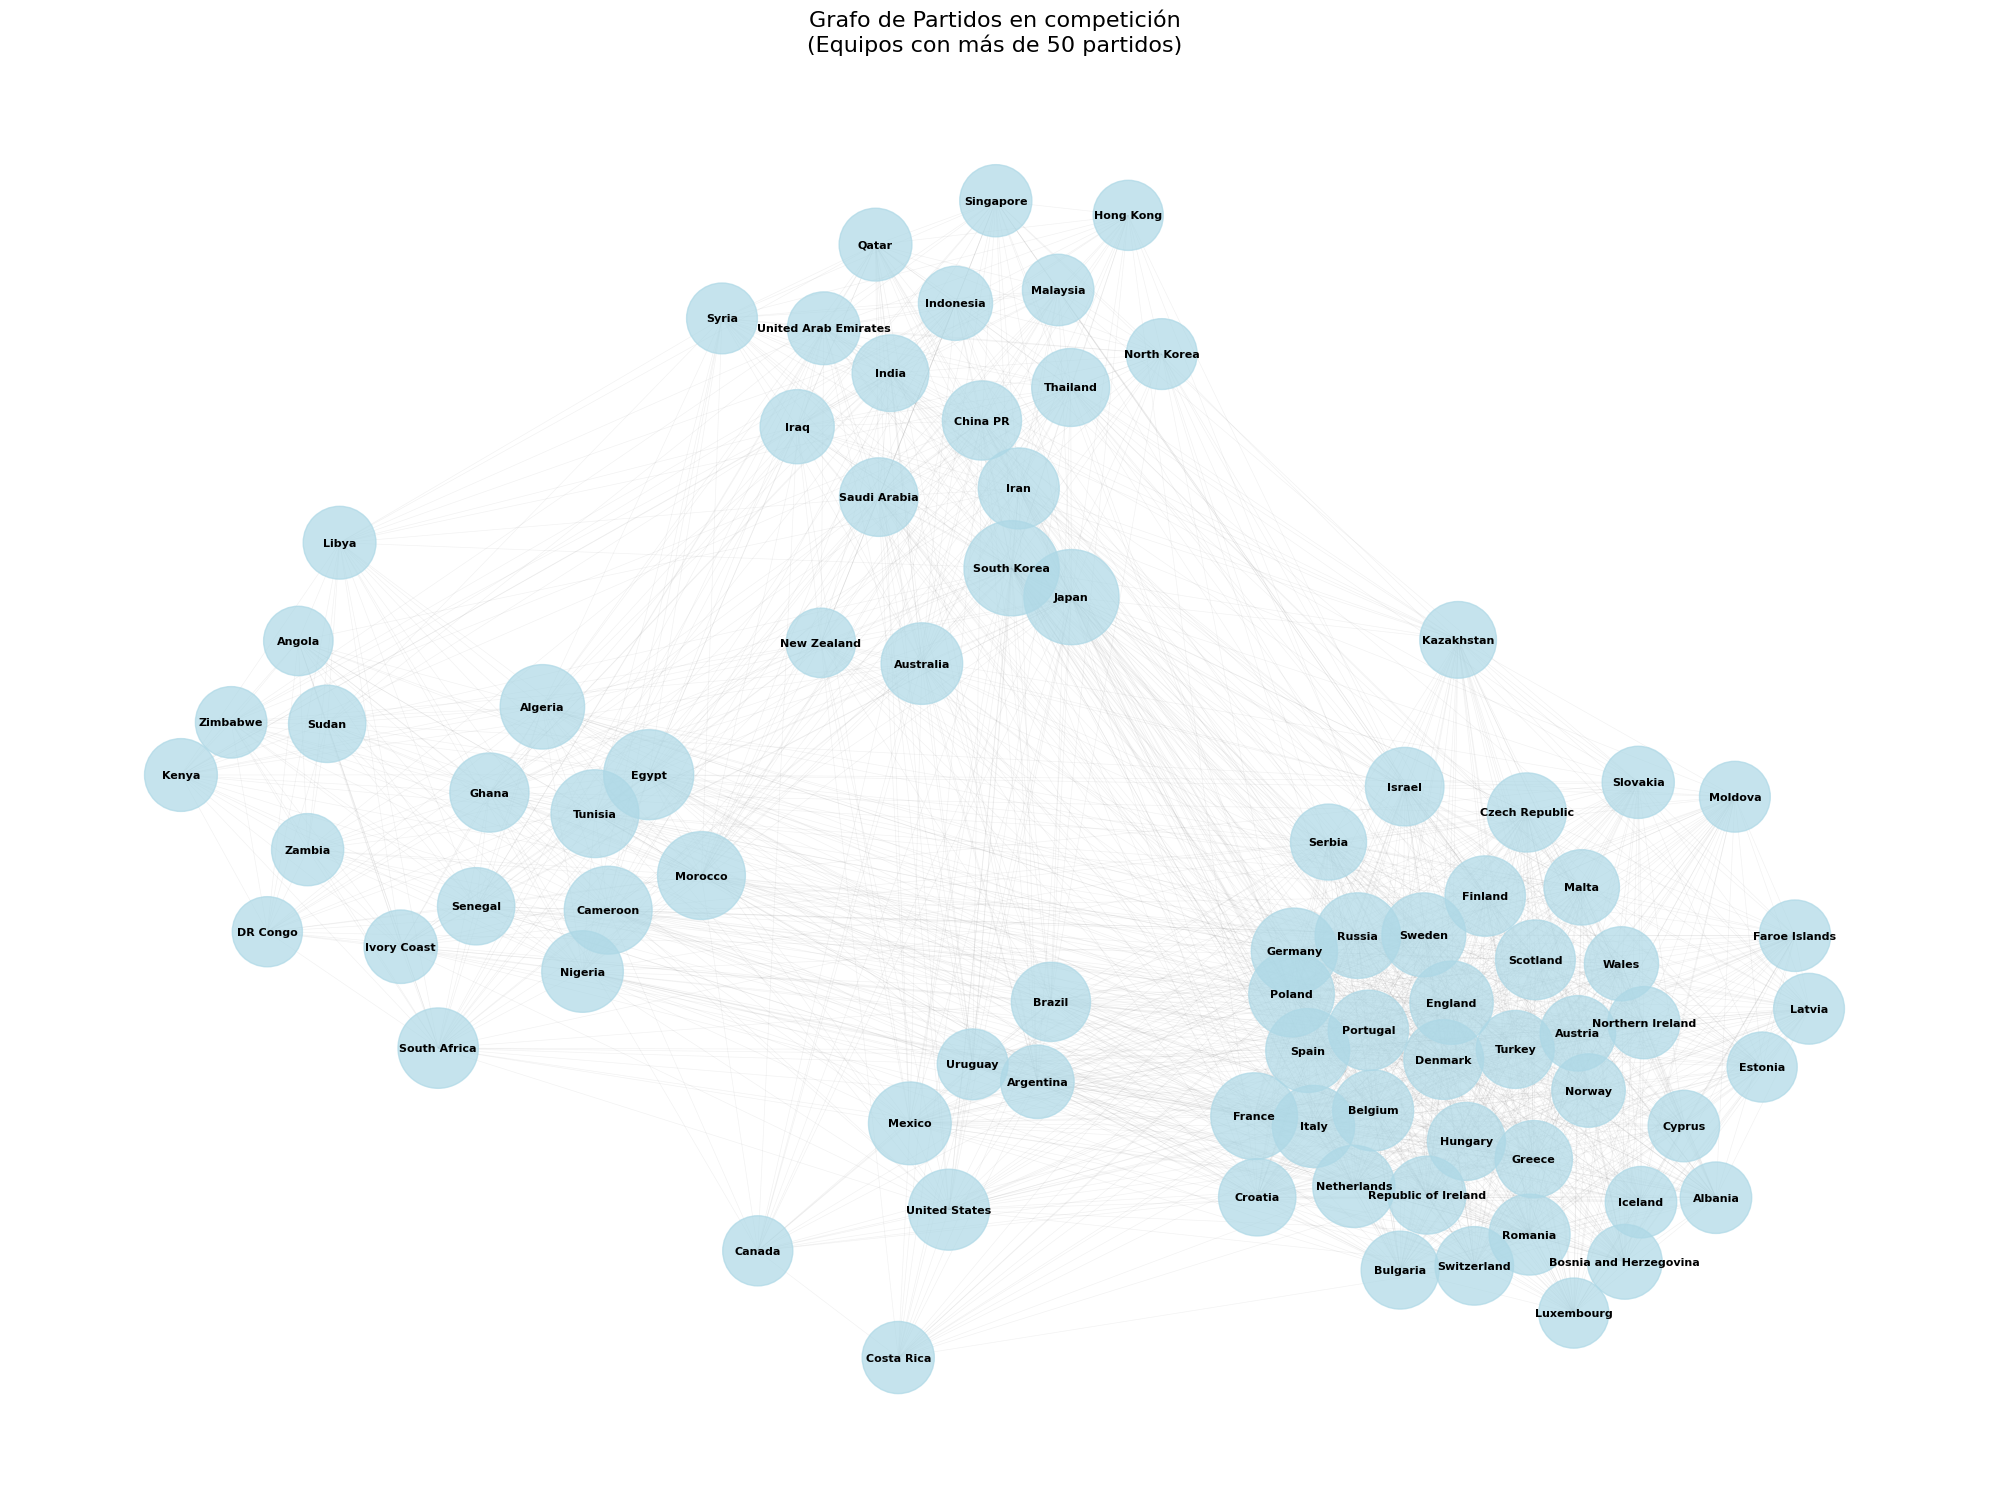

In [145]:
# Grafo donde los nodos son los equipos y las aristas son los partidos jugados entre ellos
import networkx as nx

# Cargamos los datos
data = pd.read_csv(path + "/results.csv")

# Eliminamos los partidos amistosos
data = data.loc[data['tournament'] != 'Friendly']

teams = pd.DataFrame({
    "team": np.unique(np.concatenate((data["home_team"].unique(), data["away_team"].unique())))
})

G = nx.Graph()

for index, row in data.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]

    if G.has_edge(home_team, away_team):
        G[home_team][away_team]["weight"] += 1
    else:
        G.add_edge(home_team, away_team, weight=1)

# Calcula los grados de los nodos para el tamaño
degrees = dict(G.degree())
max_degree = max(degrees.values())

# Crea un subconjunto más pequeño de nodos con alto grado para mejor visualización
min_edges = 50
significant_nodes = [node for node, degree in degrees.items() if degree >= min_edges]
G_subset = G.subgraph(significant_nodes)

plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G_subset, k=1, iterations=50, seed=42)

# Dibuja las aristas con transparencia
nx.draw_networkx_edges(G_subset, pos, 
                      alpha=0.1, 
                      edge_color='gray',
                      width=0.5)

# Dibuja los nodos con tamaño proporcional al grado
node_sizes = [degrees[node]*50 for node in G_subset.nodes()]
nx.draw_networkx_nodes(G_subset, pos,
                      node_size=node_sizes,
                      node_color='lightblue',
                      alpha=0.7)

# Añade etiquetas con tamaño de fuente más pequeño para mejor legibilidad
nx.draw_networkx_labels(G_subset, pos,
                       font_size=8,
                       font_weight='bold')

plt.title(f'Grafo de Partidos en competición\n(Equipos con más de {min_edges} partidos)', pad=20, size=16)
plt.axis('off')
plt.tight_layout()
plt.show()